# 🫁 LUNA16 Lung Cancer Detection - ResNet-101 Pretrained Model

**Transfer Learning with ResNet-101 for Medical Imaging**

### Key Features:
- 🔮 **Pretrained ResNet-101** - Transfer learning from ImageNet
- 🎯 **2D Multi-Slice Approach** - Process CT scan slices with pretrained CNN
- ⚖️ **Focal Loss** - Handle class imbalance effectively
- 📈 **Advanced Metrics** - Precision, Recall, F1, AUC-ROC
- 🚀 **Data Augmentation** - Robust training with augmented patches

**Dataset**: LUNA16 (Lung Nodule Analysis 2016)

### Approach:
- Extract 2D slices from 3D CT scans
- Use pretrained ResNet-101 backbone
- Fine-tune for nodule detection task

## 1. 📦 Import Required Libraries

In [3]:
# Core libraries
import os
import sys
import glob
import warnings
from pathlib import Path
import time
import math
import random

# Data processing
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, matthews_corrcoef
)

# Medical imaging
import SimpleITK as sitk

# PyTorch and deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from PIL import Image

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0.dev20250930+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5060 Ti


c:\Users\admin\anaconda3\envs\pytorch-12.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. ⚙️ Configuration and Setup

In [4]:
# Paths
BASE_DIR = Path(r'e:\Kanav\Projects\CAD_C')
ANNOTATIONS_FILE = BASE_DIR / 'annotations.csv'
CANDIDATES_FILE = BASE_DIR / 'candidates_V2.csv'
SUBSET_DIRS = [BASE_DIR / f'subset{i}' for i in range(10)]
MODEL_DIR = BASE_DIR / 'models_resnet101'
MODEL_DIR.mkdir(exist_ok=True)

# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'patch_size': 64,      # Size of 2D patch
    'num_slices': 3,       # Number of consecutive slices (channels)
    'patience': 10,        # Early stopping patience
    'preload_patches': True,   # Pre-extract patches for faster training (requires ~4-8 GB RAM)
    'max_samples': None,   # Limit samples for testing (None = use all)
    'sample_ratio': 3.0,   # Ratio of negative to positive samples (3:1)
    'num_workers': 0,      # Number of workers for data loading (0 for Windows)
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',  # Device to use
    'focal_alpha': 0.75,   # Focal Loss alpha parameter (weight for positive class)
    'focal_gamma': 2.0,    # Focal Loss gamma parameter (focusing parameter)
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  batch_size: 32
  num_epochs: 50
  learning_rate: 0.001
  weight_decay: 0.0001
  patch_size: 64
  num_slices: 3
  patience: 10
  preload_patches: True
  max_samples: None
  sample_ratio: 3.0
  num_workers: 0
  device: cuda
  focal_alpha: 0.75
  focal_gamma: 2.0


## 3. 📊 Load and Explore Dataset

In [5]:
# Load annotations (true nodules)
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
print(f"Annotations shape: {annotations_df.shape}")
print(f"\nAnnotations columns: {annotations_df.columns.tolist()}")
print(f"\nNumber of unique scans with nodules: {annotations_df['seriesuid'].nunique()}")
print(f"\nFirst few annotations:")
print(annotations_df.head())

# Statistics
print(f"\n📊 Annotation Statistics:")
print(f"Total nodules: {len(annotations_df)}")
print(f"Diameter range: {annotations_df['diameter_mm'].min():.2f} - {annotations_df['diameter_mm'].max():.2f} mm")
print(f"Mean diameter: {annotations_df['diameter_mm'].mean():.2f} mm")

Annotations shape: (1186, 5)

Annotations columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm']

Number of unique scans with nodules: 601

First few annotations:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  

📊 Annotation Statistics:
Total nodules: 1186
Diameter range: 3.25 - 32.27 mm
Mean diameter: 8.31 mm


In [6]:
# Load candidates (mix of nodules and non-nodules)
# Since candidates_V2.csv is large, we'll load it in chunks
print("Loading candidates file (this may take a moment)...")

try:
    # Try loading with chunking for large files
    chunk_size = 100000
    chunks = []
    for chunk in pd.read_csv(CANDIDATES_FILE, chunksize=chunk_size):
        chunks.append(chunk)
    candidates_df = pd.concat(chunks, ignore_index=True)
    print(f"✓ Successfully loaded candidates file")
except Exception as e:
    print(f"Error loading candidates: {e}")
    # Fallback: load first N rows
    candidates_df = pd.read_csv(CANDIDATES_FILE, nrows=100000)
    print(f"✓ Loaded first 100,000 candidates")

print(f"\nCandidates shape: {candidates_df.shape}")
print(f"Candidates columns: {candidates_df.columns.tolist()}")
print(f"\nClass distribution:")
print(candidates_df['class'].value_counts())
print(f"\nPositive rate: {candidates_df['class'].mean()*100:.2f}%")
print(f"\nFirst few candidates:")
print(candidates_df.head())

Loading candidates file (this may take a moment)...
✓ Successfully loaded candidates file

Candidates shape: (754975, 5)
Candidates columns: ['seriesuid', 'coordX', 'coordY', 'coordZ', 'class']

Class distribution:
class
0    753418
1      1557
Name: count, dtype: int64

Positive rate: 0.21%

First few candidates:
                                           seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0  
✓ Successfully loaded candidates file

Candidates shape: (754975, 5)
Ca

## 4. 🔧 Utility Functions for CT Scan Processing

In [7]:
def load_ct_scan(series_uid, subset_dirs):
    """
    Load CT scan from .mhd/.raw files
    
    Args:
        series_uid: Unique identifier for the CT scan
        subset_dirs: List of directories to search
    
    Returns:
        SimpleITK Image object or None if not found
    """
    for subset_dir in subset_dirs:
        mhd_path = subset_dir / f"{series_uid}.mhd"
        if mhd_path.exists():
            try:
                ct_scan = sitk.ReadImage(str(mhd_path))
                return ct_scan
            except Exception as e:
                print(f"Error loading {mhd_path}: {e}")
                return None
    return None

def world_to_voxel(world_coords, origin, spacing):
    """
    Convert world coordinates to voxel coordinates
    
    Args:
        world_coords: (x, y, z) in world coordinates (mm)
        origin: Origin of the image
        spacing: Voxel spacing
    
    Returns:
        (z, y, x) voxel coordinates
    """
    world_coords = np.array(world_coords)
    origin = np.array(origin)
    spacing = np.array(spacing)
    voxel_coords = (world_coords - origin) / spacing
    # Return as (z, y, x) for numpy indexing
    return int(voxel_coords[2]), int(voxel_coords[1]), int(voxel_coords[0])

def normalize_hu(image):
    """
    Normalize CT Hounsfield Units to 0-1 range
    Lung window: -1000 to 400 HU
    """
    MIN_HU = -1000
    MAX_HU = 400
    image = np.clip(image, MIN_HU, MAX_HU)
    image = (image - MIN_HU) / (MAX_HU - MIN_HU)
    return image.astype(np.float32)

def extract_2d_patch(ct_array, center_z, center_y, center_x, patch_size=64, num_slices=3):
    """
    Extract 2D multi-slice patch centered at given coordinates
    
    Args:
        ct_array: 3D CT scan array (z, y, x)
        center_z, center_y, center_x: Center coordinates
        patch_size: Size of the 2D patch
        num_slices: Number of consecutive slices to extract
    
    Returns:
        3D patch array (num_slices, patch_size, patch_size) or None if out of bounds
    """
    half_size = patch_size // 2
    half_slices = num_slices // 2
    
    z_start = center_z - half_slices
    z_end = z_start + num_slices
    y_start = center_y - half_size
    y_end = center_y + half_size
    x_start = center_x - half_size
    x_end = center_x + half_size
    
    # Check bounds
    if (z_start < 0 or z_end > ct_array.shape[0] or
        y_start < 0 or y_end > ct_array.shape[1] or
        x_start < 0 or x_end > ct_array.shape[2]):
        return None
    
    # Extract patch
    patch = ct_array[z_start:z_end, y_start:y_end, x_start:x_end]
    
    # Normalize
    patch = normalize_hu(patch)
    
    return patch

print("✓ Utility functions defined")

✓ Utility functions defined


## 5. 🎯 Dataset Class

In [8]:
class LUNA16Dataset(Dataset):
    """
    PyTorch Dataset for LUNA16 with 2D multi-slice patches
    Supports pre-extraction for faster training
    """
    
    def __init__(self, candidates_df, subset_dirs, patch_size=64, num_slices=3, 
                 augment=False, max_samples=None, preload=False):
        """
        Args:
            candidates_df: DataFrame with candidate locations and labels
            subset_dirs: List of directories containing CT scans
            patch_size: Size of 2D patch
            num_slices: Number of consecutive slices (channels)
            augment: Whether to apply data augmentation
            max_samples: Maximum number of samples to use
            preload: Whether to preload all patches into memory
        """
        self.candidates_df = candidates_df.copy()
        if max_samples is not None and len(self.candidates_df) > max_samples:
            self.candidates_df = self.candidates_df.sample(n=max_samples, random_state=SEED)
        
        self.subset_dirs = subset_dirs
        self.patch_size = patch_size
        self.num_slices = num_slices
        self.augment = augment
        self.preload = preload
        
        # Cache for loaded CT scans
        self.ct_cache = {}
        
        # Cache for extracted patches (used when preload=True)
        self.patch_cache = {}
        
        print(f"Dataset initialized with {len(self.candidates_df)} samples")
        print(f"  Positive: {self.candidates_df['class'].sum()}")
        print(f"  Negative: {(self.candidates_df['class'] == 0).sum()}")
        
        if self.preload:
            print(f"  Preloading patches into memory...")
            self._preload_patches()
    
    def _preload_patches(self):
        """
        Pre-extract all patches and store in memory
        Memory efficient: processes one CT scan at a time
        """
        from tqdm.auto import tqdm
        
        successful = 0
        failed = 0
        
        # Group samples by series_uid to process one CT scan at a time
        grouped = self.candidates_df.groupby('seriesuid')
        
        for series_uid, group in tqdm(grouped, desc="Processing CT scans"):
            # Load CT scan
            ct_scan = load_ct_scan(series_uid, self.subset_dirs)
            if ct_scan is None:
                # Add dummy patches for all samples from this scan
                for idx in group.index:
                    label = int(group.loc[idx, 'class'])
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                continue
            
            # Convert to numpy array
            ct_array = sitk.GetArrayFromImage(ct_scan)  # (z, y, x)
            origin = ct_scan.GetOrigin()
            spacing = ct_scan.GetSpacing()
            
            # Process all samples from this CT scan
            for idx in group.index:
                row = group.loc[idx]
                coord_x = row['coordX']
                coord_y = row['coordY']
                coord_z = row['coordZ']
                label = int(row['class'])
                
                # Convert world coordinates to voxel coordinates
                voxel_z, voxel_y, voxel_x = world_to_voxel(
                    [coord_x, coord_y, coord_z], origin, spacing
                )
                
                # Extract patch
                patch = extract_2d_patch(
                    ct_array, voxel_z, voxel_y, voxel_x, 
                    self.patch_size, self.num_slices
                )
                
                if patch is None:
                    self.patch_cache[idx] = (torch.zeros(self.num_slices, self.patch_size, self.patch_size), label)
                    failed += 1
                else:
                    # Convert to tensor
                    patch = torch.from_numpy(patch).float()
                    self.patch_cache[idx] = (patch, label)
                    successful += 1
            
            # Clear CT array to free memory
            del ct_array, ct_scan
        
        print(f"\n  ✓ Preloading completed:")
        print(f"    Successful: {successful}")
        print(f"    Failed: {failed}")
        print(f"    Total patches in memory: {len(self.patch_cache)}")
    
    def __len__(self):
        return len(self.candidates_df)
    
    def __getitem__(self, idx):
        # Get the actual DataFrame index (not positional index)
        df_idx = self.candidates_df.index[idx]
        
        # If preloaded, return from cache
        if self.preload and df_idx in self.patch_cache:
            patch, label = self.patch_cache[df_idx]
            patch = patch.clone()  # Clone to avoid modifying cached data
            
            # Apply augmentation
            if self.augment:
                patch = self.apply_augmentation(patch)
            
            return patch, label
        
        # Otherwise, extract on-the-fly
        row = self.candidates_df.iloc[idx]
        series_uid = row['seriesuid']
        coord_x = row['coordX']
        coord_y = row['coordY']
        coord_z = row['coordZ']
        label = int(row['class'])
        
        # Load CT scan (use cache)
        if series_uid not in self.ct_cache:
            ct_scan = load_ct_scan(series_uid, self.subset_dirs)
            if ct_scan is None:
                # Return dummy data if scan not found
                patch = torch.zeros(self.num_slices, self.patch_size, self.patch_size)
                return patch, label
            
            # Convert to numpy array
            ct_array = sitk.GetArrayFromImage(ct_scan)  # (z, y, x)
            origin = ct_scan.GetOrigin()
            spacing = ct_scan.GetSpacing()
            
            self.ct_cache[series_uid] = {
                'array': ct_array,
                'origin': origin,
                'spacing': spacing
            }
        
        ct_data = self.ct_cache[series_uid]
        ct_array = ct_data['array']
        origin = ct_data['origin']
        spacing = ct_data['spacing']
        
        # Convert world coordinates to voxel coordinates
        voxel_z, voxel_y, voxel_x = world_to_voxel(
            [coord_x, coord_y, coord_z], origin, spacing
        )
        
        # Extract patch
        patch = extract_2d_patch(
            ct_array, voxel_z, voxel_y, voxel_x, 
            self.patch_size, self.num_slices
        )
        
        if patch is None:
            # Return dummy data if patch extraction failed
            patch = torch.zeros(self.num_slices, self.patch_size, self.patch_size)
            return patch, label
        
        # Convert to tensor
        patch = torch.from_numpy(patch).float()
        
        # Apply augmentation
        if self.augment:
            patch = self.apply_augmentation(patch)
        
        return patch, label
    
    def apply_augmentation(self, patch):
        """
        Apply random augmentations
        """
        # Random horizontal flip
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[2])
        
        # Random vertical flip
        if random.random() > 0.5:
            patch = torch.flip(patch, dims=[1])
        
        # Random rotation (90, 180, 270 degrees)
        if random.random() > 0.5:
            k = random.randint(1, 3)
            patch = torch.rot90(patch, k, dims=[1, 2])
        
        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = 0.8 + random.random() * 0.4  # 0.8 to 1.2
            patch = torch.clamp(patch * brightness_factor, 0, 1)
        
        return patch

print("✓ Dataset class defined")

✓ Dataset class defined


## 6. 🏗️ ResNet-101 Model Architecture

In [9]:
class ResNet101LungCancer(nn.Module):
    """
    ResNet-101 pretrained model adapted for lung cancer detection
    """
    
    def __init__(self, pretrained=True, num_classes=2, dropout=0.5):
        super(ResNet101LungCancer, self).__init__()
        
        # Load pretrained ResNet-101
        self.resnet = models.resnet101(pretrained=pretrained)
        
        # Get number of features from the last layer
        num_features = self.resnet.fc.in_features
        
        # Replace the final fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
        
        print(f"✓ ResNet-101 initialized (pretrained={pretrained})")
        print(f"  Total parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"  Trainable parameters: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")
    
    def forward(self, x):
        return self.resnet(x)
    
    def freeze_backbone(self):
        """Freeze all layers except the final classifier"""
        for name, param in self.resnet.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False
        print("✓ Backbone frozen, only training final classifier")
    
    def unfreeze_backbone(self):
        """Unfreeze all layers for fine-tuning"""
        for param in self.resnet.parameters():
            param.requires_grad = True
        print("✓ Backbone unfrozen, training all layers")

print("✓ Model class defined")

✓ Model class defined


## 7. 📉 Focal Loss for Class Imbalance

In [10]:
class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    """
    
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: (N, C) logits
            targets: (N,) class labels
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        p = torch.exp(-ce_loss)
        
        # Apply alpha weighting
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        # Apply focal term
        focal_loss = alpha_t * (1 - p) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss defined")

✓ Focal Loss defined


## 8. 📊 Prepare Data Loaders

In [11]:
# Balance the dataset
print("Preparing balanced dataset...")

# Separate positive and negative samples
positive_samples = candidates_df[candidates_df['class'] == 1]
negative_samples = candidates_df[candidates_df['class'] == 0]

print(f"Original distribution:")
print(f"  Positive: {len(positive_samples)}")
print(f"  Negative: {len(negative_samples)}")

# Sample negatives to match positives (with some ratio)
n_positive = len(positive_samples)
n_negative = int(n_positive * CONFIG['sample_ratio'])
n_negative = min(n_negative, len(negative_samples))

negative_samples_sampled = negative_samples.sample(n=n_negative, random_state=SEED)

# Combine
balanced_df = pd.concat([positive_samples, negative_samples_sampled], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # Shuffle

print(f"\nBalanced distribution:")
print(f"  Positive: {(balanced_df['class'] == 1).sum()}")
print(f"  Negative: {(balanced_df['class'] == 0).sum()}")
print(f"  Total: {len(balanced_df)}")

# Split into train, validation, and test sets
train_df, temp_df = train_test_split(
    balanced_df, test_size=0.3, random_state=SEED, stratify=balanced_df['class']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['class']
)

print(f"\nData splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(test_df)} samples")

Preparing balanced dataset...
Original distribution:
  Positive: 1557
  Negative: 753418

Balanced distribution:
  Positive: 1557
  Negative: 4671
  Total: 6228

Data splits:
  Train: 4359 samples
  Validation: 934 samples
  Test: 935 samples


### 🚀 Pre-Extract Patches for Faster Training

**Benefits of Pre-Extraction:**
- ⚡ **10-100x Faster Training** - No I/O bottleneck during training
- 🎯 **Consistent Performance** - Each epoch takes the same time
- 💾 **Memory Trade-off** - Uses more RAM but saves hours of training time

**How it works:**
1. Extract all patches from CT scans once
2. Store patches in memory (RAM)
3. Training reads from memory instead of disk

**Note:** If you run out of memory, set `CONFIG['preload_patches'] = False` in the configuration cell above.

In [12]:
# Create datasets with optional pre-extraction
if CONFIG['preload_patches']:
    print("Creating datasets with patch pre-extraction...")
    print("This will take some time but will speed up training significantly!\n")
else:
    print("Creating datasets (patches will be extracted on-the-fly during training)...\n")

train_dataset = LUNA16Dataset(
    train_df, SUBSET_DIRS, 
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=True,
    max_samples=None,  # Use all training samples
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

val_dataset = LUNA16Dataset(
    val_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    max_samples=None,
    preload=CONFIG['preload_patches']
)

print("\n" + "-"*60 + "\n")

test_dataset = LUNA16Dataset(
    test_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,
    max_samples=None,
    preload=CONFIG['preload_patches']
)

print("\n" + "="*60)
if CONFIG['preload_patches']:
    print("✓ All datasets created with patches pre-extracted and cached in memory")
else:
    print("✓ All datasets created (on-the-fly extraction enabled)")
print("="*60)

Creating datasets with patch pre-extraction...
This will take some time but will speed up training significantly!

Dataset initialized with 4359 samples
  Positive: 1090
  Negative: 3269
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 862/862 [04:50<00:00,  2.96it/s]



  ✓ Preloading completed:
    Successful: 4316
    Failed: 43
    Total patches in memory: 4359

------------------------------------------------------------

Dataset initialized with 934 samples
  Positive: 233
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 548/548 [02:15<00:00,  4.04it/s]



  ✓ Preloading completed:
    Successful: 925
    Failed: 9
    Total patches in memory: 934

------------------------------------------------------------

Dataset initialized with 935 samples
  Positive: 234
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 552/552 [02:11<00:00,  4.19it/s]


  ✓ Preloading completed:
    Successful: 925
    Failed: 10
    Total patches in memory: 935

✓ All datasets created with patches pre-extracted and cached in memory


In [13]:
# Check memory usage of preloaded datasets
if CONFIG['preload_patches']:
    import sys

    def get_size_mb(obj):
        """Get approximate size of object in MB"""
        size_bytes = sys.getsizeof(obj)
        # For datasets, estimate based on patch cache
        if hasattr(obj, 'patch_cache'):
            for patch, label in obj.patch_cache.values():
                size_bytes += patch.element_size() * patch.nelement()
        return size_bytes / (1024 * 1024)

    print("\n📊 Memory Usage Estimates:")
    print(f"  Train dataset: ~{get_size_mb(train_dataset):.2f} MB")
    print(f"  Val dataset: ~{get_size_mb(val_dataset):.2f} MB")
    print(f"  Test dataset: ~{get_size_mb(test_dataset):.2f} MB")
    total_mb = get_size_mb(train_dataset) + get_size_mb(val_dataset) + get_size_mb(test_dataset)
    print(f"  Total: ~{total_mb:.2f} MB ({total_mb/1024:.2f} GB)")
    print("\n💡 Benefit: Training will be much faster with pre-extracted patches!")
else:
    print("\n💡 Pre-extraction is disabled. Patches will be loaded on-the-fly during training.")


📊 Memory Usage Estimates:
  Train dataset: ~204.33 MB
  Val dataset: ~43.78 MB
  Test dataset: ~43.83 MB
  Total: ~291.94 MB (0.29 GB)

💡 Benefit: Training will be much faster with pre-extracted patches!


In [14]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print(f"✓ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✓ Data loaders created
  Train batches: 137
  Validation batches: 30
  Test batches: 30


## 9. 🎓 Training Functions

In [15]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training', leave=False)
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    # Calculate metrics
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    # ROC-AUC
    try:
        auc_score = roc_auc_score(all_labels, all_probs)
    except:
        auc_score = 0.0
    
    # F1 Score
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    return epoch_loss, epoch_acc, auc_score, f1, all_labels, all_preds, all_probs

print("✓ Training functions defined")

✓ Training functions defined


## 10. 🚀 Initialize Model and Training

In [16]:
# Initialize model
device = torch.device(CONFIG['device'])
model = ResNet101LungCancer(pretrained=True, num_classes=2, dropout=0.5)
model = model.to(device)

# Loss function
criterion = FocalLoss(
    alpha=CONFIG['focal_alpha'],
    gamma=CONFIG['focal_gamma']
)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("✓ Model, loss, optimizer, and scheduler initialized")

✓ ResNet-101 initialized (pretrained=True)
  Total parameters: 43,550,274
  Trainable parameters: 43,550,274
✓ Model, loss, optimizer, and scheduler initialized


## 11. 🏋️ Train the Model

In [17]:
# Training loop
print("Starting training...\n")

best_val_auc = 0.0
best_val_f1 = 0.0
patience_counter = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_auc': [],
    'val_f1': []
}

for epoch in range(CONFIG['num_epochs']):
    epoch_start_time = time.time()
    
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_f1'].append(val_f1)
    
    epoch_time = time.time() - epoch_start_time
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Val AUC: {val_auc:.4f} | Val F1: {val_f1:.4f}")
    print(f"Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'val_f1': val_f1,
        }, MODEL_DIR / 'best_resnet101_model.pth')
        print(f"✓ Saved best model (AUC: {val_auc:.4f}, F1: {val_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*60)
print("Training completed!")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Best Validation F1: {best_val_f1:.4f}")
print("="*60)

Starting training...


Epoch 1/50
------------------------------------------------------------



Train Loss: 0.0885 | Train Acc: 51.02%
Val Loss: 0.0623 | Val Acc: 49.57%
Val AUC: 0.6960 | Val F1: 0.4542
Time: 9.62s
✓ Saved best model (AUC: 0.6960, F1: 0.4542)

Epoch 2/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.6960, F1: 0.4542)

Epoch 2/50
------------------------------------------------------------



Train Loss: 0.0540 | Train Acc: 72.31%
Val Loss: 0.0366 | Val Acc: 82.33%
Val AUC: 0.9314 | Val F1: 0.7208
Time: 9.80s
✓ Saved best model (AUC: 0.9314, F1: 0.7208)

Epoch 3/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9314, F1: 0.7208)

Epoch 3/50
------------------------------------------------------------



Train Loss: 0.0399 | Train Acc: 83.57%
Val Loss: 1.8047 | Val Acc: 72.48%
Val AUC: 0.6466 | Val F1: 0.4911
Time: 14.03s

Epoch 4/50
------------------------------------------------------------



Train Loss: 0.0384 | Train Acc: 85.16%
Val Loss: 0.1349 | Val Acc: 81.16%
Val AUC: 0.9345 | Val F1: 0.7096
Time: 16.83s
✓ Saved best model (AUC: 0.9345, F1: 0.7096)

Epoch 5/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9345, F1: 0.7096)

Epoch 5/50
------------------------------------------------------------



Train Loss: 0.0360 | Train Acc: 85.62%
Val Loss: 0.0321 | Val Acc: 91.22%
Val AUC: 0.9569 | Val F1: 0.8057
Time: 16.30s
✓ Saved best model (AUC: 0.9569, F1: 0.8057)

Epoch 6/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9569, F1: 0.8057)

Epoch 6/50
------------------------------------------------------------



Train Loss: 0.0292 | Train Acc: 89.22%
Val Loss: 0.1241 | Val Acc: 79.55%
Val AUC: 0.8694 | Val F1: 0.6713
Time: 16.30s

Epoch 7/50
------------------------------------------------------------



Train Loss: 0.0324 | Train Acc: 86.07%
Val Loss: 0.0297 | Val Acc: 85.22%
Val AUC: 0.9477 | Val F1: 0.7500
Time: 16.46s

Epoch 8/50
------------------------------------------------------------



Train Loss: 0.0295 | Train Acc: 87.70%
Val Loss: 0.0210 | Val Acc: 92.83%
Val AUC: 0.9778 | Val F1: 0.8607
Time: 16.25s
✓ Saved best model (AUC: 0.9778, F1: 0.8607)

Epoch 9/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9778, F1: 0.8607)

Epoch 9/50
------------------------------------------------------------



Train Loss: 0.0267 | Train Acc: 89.22%
Val Loss: 0.0200 | Val Acc: 92.29%
Val AUC: 0.9778 | Val F1: 0.8543
Time: 15.81s

Epoch 10/50
------------------------------------------------------------



Train Loss: 0.0262 | Train Acc: 89.88%
Val Loss: 0.0268 | Val Acc: 89.40%
Val AUC: 0.9696 | Val F1: 0.8170
Time: 15.05s

Epoch 11/50
------------------------------------------------------------



Train Loss: 0.0222 | Train Acc: 91.74%
Val Loss: 0.0286 | Val Acc: 94.00%
Val AUC: 0.9805 | Val F1: 0.8828
Time: 15.20s
✓ Saved best model (AUC: 0.9805, F1: 0.8828)

Epoch 12/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9805, F1: 0.8828)

Epoch 12/50
------------------------------------------------------------



Train Loss: 0.0205 | Train Acc: 91.90%
Val Loss: 0.0156 | Val Acc: 94.22%
Val AUC: 0.9860 | Val F1: 0.8851
Time: 15.25s
✓ Saved best model (AUC: 0.9860, F1: 0.8851)

Epoch 13/50
------------------------------------------------------------
✓ Saved best model (AUC: 0.9860, F1: 0.8851)

Epoch 13/50
------------------------------------------------------------



Train Loss: 0.0209 | Train Acc: 91.42%
Val Loss: 0.0260 | Val Acc: 91.76%
Val AUC: 0.9628 | Val F1: 0.8351
Time: 15.63s

Epoch 14/50
------------------------------------------------------------



Train Loss: 0.0228 | Train Acc: 92.27%
Val Loss: 0.0180 | Val Acc: 93.58%
Val AUC: 0.9812 | Val F1: 0.8765
Time: 12.14s

Epoch 15/50
------------------------------------------------------------



Train Loss: 0.0359 | Train Acc: 86.24%
Val Loss: 0.0301 | Val Acc: 86.08%
Val AUC: 0.9456 | Val F1: 0.7510
Time: 15.35s

Epoch 16/50
------------------------------------------------------------



Train Loss: 0.0319 | Train Acc: 85.80%
Val Loss: 0.0279 | Val Acc: 86.62%
Val AUC: 0.9481 | Val F1: 0.7515
Time: 15.39s

Epoch 17/50
------------------------------------------------------------



Train Loss: 0.0266 | Train Acc: 90.46%
Val Loss: 0.0843 | Val Acc: 85.97%
Val AUC: 0.9482 | Val F1: 0.7745
Time: 15.31s

Epoch 18/50
------------------------------------------------------------



Train Loss: 0.0402 | Train Acc: 86.79%
Val Loss: 0.0434 | Val Acc: 84.69%
Val AUC: 0.9119 | Val F1: 0.7191
Time: 14.85s

Epoch 19/50
------------------------------------------------------------



Train Loss: 0.0391 | Train Acc: 83.76%
Val Loss: 0.0280 | Val Acc: 85.97%
Val AUC: 0.9513 | Val F1: 0.7533
Time: 15.32s

Epoch 20/50
------------------------------------------------------------



Train Loss: 0.0313 | Train Acc: 87.77%
Val Loss: 0.0212 | Val Acc: 90.69%
Val AUC: 0.9749 | Val F1: 0.8291
Time: 15.07s

Epoch 21/50
------------------------------------------------------------



Train Loss: 0.0256 | Train Acc: 89.81%
Val Loss: 0.0221 | Val Acc: 90.58%
Val AUC: 0.9695 | Val F1: 0.8281
Time: 15.73s

Epoch 22/50
------------------------------------------------------------



Train Loss: 0.0211 | Train Acc: 91.31%
Val Loss: 0.0167 | Val Acc: 92.29%
Val AUC: 0.9822 | Val F1: 0.8571
Time: 17.67s

Early stopping triggered after 22 epochs

Training completed!
Best Validation AUC: 0.9860
Best Validation F1: 0.8851


## 12. 📈 Plot Training History

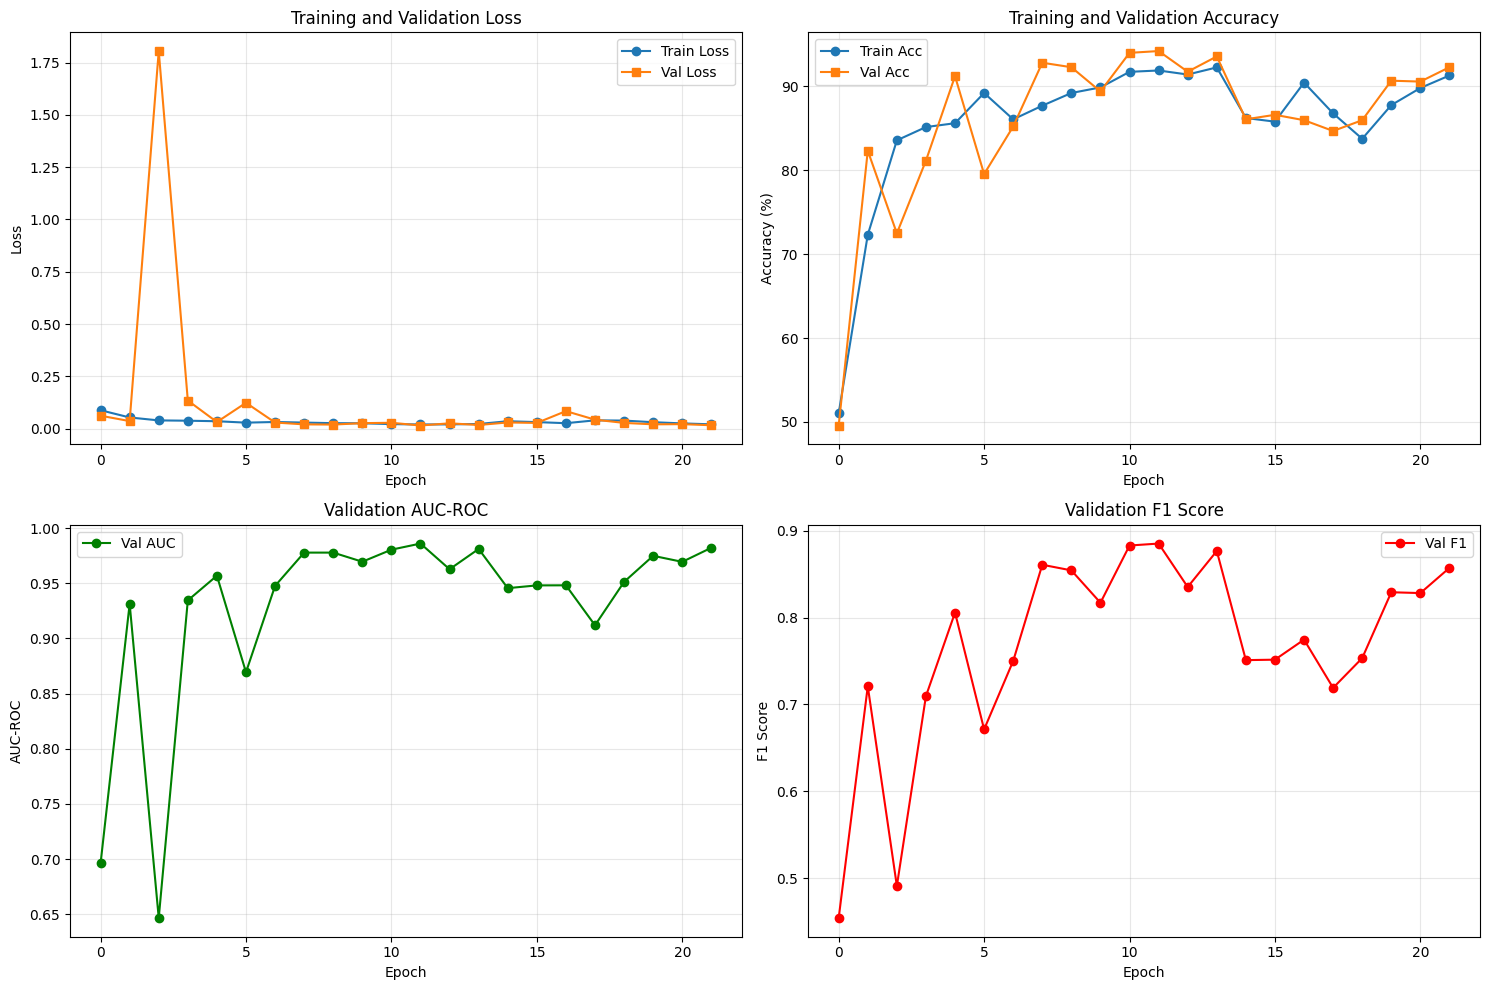

✓ Training history saved


In [18]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history['val_auc'], label='Val AUC', marker='o', color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC-ROC')
axes[1, 0].set_title('Validation AUC-ROC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# F1 Score
axes[1, 1].plot(history['val_f1'], label='Val F1', marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Validation F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved")

## 13. 🧪 Evaluate on Test Set

In [19]:
# Load best model
checkpoint = torch.load(MODEL_DIR / 'best_resnet101_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_auc, test_f1, test_labels, test_preds, test_probs = validate(
    model, test_loader, criterion, device
)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("="*60)

✓ Loaded best model from epoch 12

Evaluating on test set...



TEST SET RESULTS
Test Loss: 0.0210
Test Accuracy: 94.44%
Test AUC-ROC: 0.9772
Test F1 Score: 0.8903


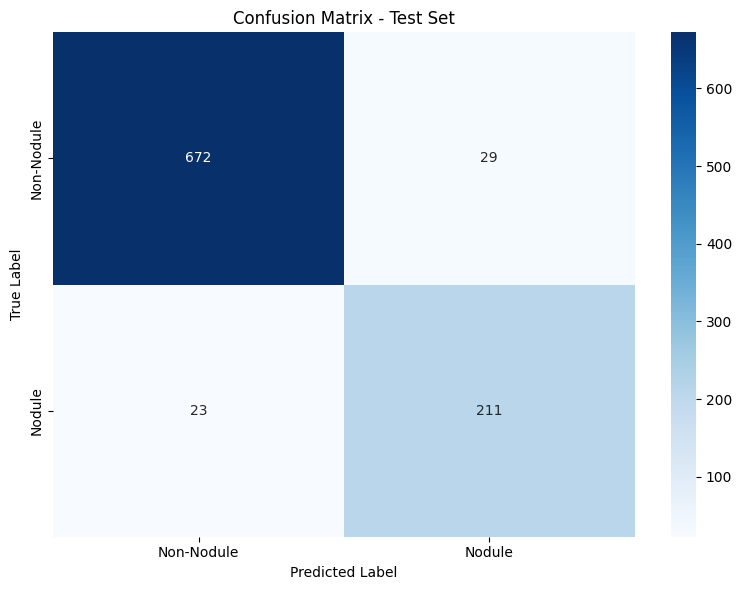


Confusion Matrix:
[[672  29]
 [ 23 211]]


In [20]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Nodule', 'Nodule'],
            yticklabels=['Non-Nodule', 'Nodule'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig(MODEL_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, 
                          target_names=['Non-Nodule', 'Nodule'],
                          digits=4))


Classification Report:
              precision    recall  f1-score   support

  Non-Nodule     0.9669    0.9586    0.9628       701
      Nodule     0.8792    0.9017    0.8903       234

    accuracy                         0.9444       935
   macro avg     0.9230    0.9302    0.9265       935
weighted avg     0.9449    0.9444    0.9446       935



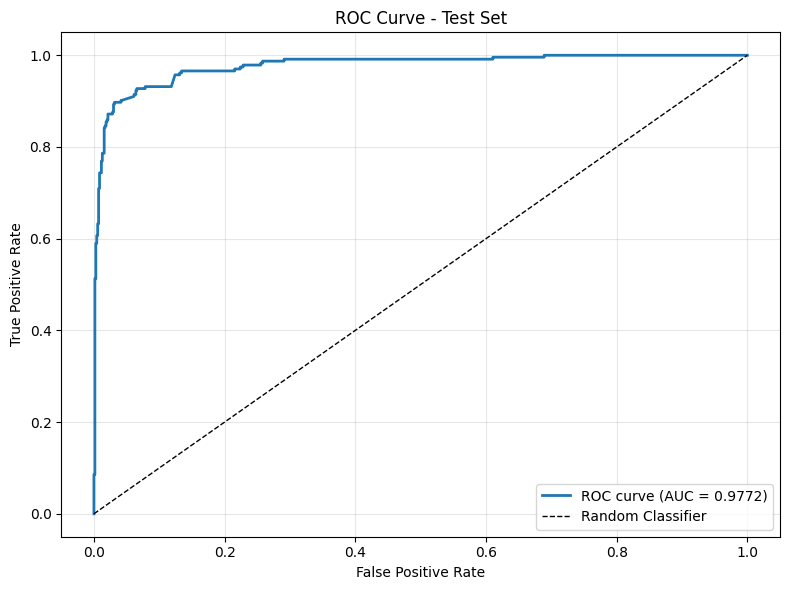

In [22]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

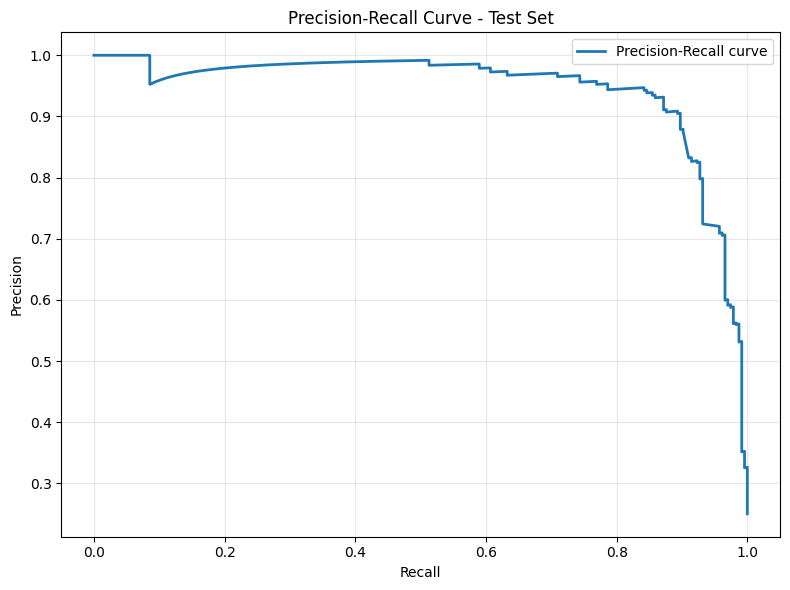

In [23]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(MODEL_DIR / 'precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 💾 Save Results

In [24]:
# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(MODEL_DIR / 'training_history.csv', index=False)
print("✓ Training history saved")

# Save test results
test_results = {
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_auc': test_auc,
    'test_f1': test_f1,
    'confusion_matrix': cm.tolist()
}

import json
with open(MODEL_DIR / 'test_results.json', 'w') as f:
    json.dump(test_results, f, indent=4)
print("✓ Test results saved")

print(f"\n✓ All results saved to {MODEL_DIR}")

✓ Training history saved
✓ Test results saved

✓ All results saved to e:\Kanav\Projects\CAD_C\models_resnet101


## 15. 🎯 Summary

### Model Architecture:
- **Backbone**: Pretrained ResNet-101 (ImageNet weights)
- **Input**: 2D multi-slice patches (3 consecutive slices as RGB channels)
- **Output**: Binary classification (Nodule / Non-Nodule)

### Training Strategy:
- **Loss Function**: Focal Loss for class imbalance
- **Optimizer**: AdamW with weight decay
- **Learning Rate**: Adaptive with ReduceLROnPlateau
- **Data Augmentation**: Flips, rotations, brightness adjustments

### Performance Metrics:
- Accuracy, Precision, Recall, F1-Score
- AUC-ROC for overall performance
- Confusion Matrix for error analysis

### Next Steps:
1. **Fine-tuning**: Unfreeze more layers for better adaptation
2. **Ensemble**: Combine multiple models for improved accuracy
3. **3D Extension**: Use ResNet3D or Med3D for full 3D processing
4. **Deployment**: Export model for clinical use

## 16. 🔧 Fine-Tuning for Enhanced Performance

### Fine-Tuning Strategy:
- **Unfreeze Backbone**: Allow ResNet-101 layers to adapt to medical imaging
- **Lower Learning Rate**: Use smaller LR for pretrained features
- **Advanced Augmentation**: More sophisticated data transformations
- **Cosine Annealing**: Better learning rate scheduling
- **Early Stopping**: Prevent overfitting during fine-tuning

**Goal**: Improve beyond current performance with specialized medical imaging adaptation

In [25]:
# Enhanced Data Augmentation for Fine-Tuning (Fixed)
class AdvancedAugmentation:
    """Advanced augmentation pipeline for fine-tuning - Robust version"""
    
    def __init__(self):
        pass
    
    @staticmethod
    def apply_advanced_augmentation(patch):
        """Apply advanced augmentation techniques - simplified and robust"""
        # Ensure patch is a tensor
        if not isinstance(patch, torch.Tensor):
            patch = torch.from_numpy(patch).float()
        
        # Random noise injection
        if random.random() > 0.6:
            noise = torch.randn_like(patch) * 0.05
            patch = torch.clamp(patch + noise, 0, 1)
        
        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = 0.8 + random.random() * 0.4  # 0.8 to 1.2
            patch = torch.clamp(patch * brightness_factor, 0, 1)
        
        # Random contrast adjustment (simplified)
        if random.random() > 0.5:
            contrast_factor = 0.8 + random.random() * 0.4  # 0.8 to 1.2
            mean = patch.mean()
            patch = torch.clamp((patch - mean) * contrast_factor + mean, 0, 1)
        
        # Random gamma correction
        if random.random() > 0.5:
            gamma = 0.8 + random.random() * 0.4  # 0.8 to 1.2
            patch = torch.clamp(torch.pow(patch + 1e-7, gamma), 0, 1)  # Add small epsilon to avoid pow(0)
        
        return patch

# Enhanced Dataset Class (Fixed)
class AdvancedLUNA16Dataset(LUNA16Dataset):
    """Enhanced dataset with advanced augmentation for fine-tuning - Fixed version"""
    
    def apply_augmentation(self, patch):
        """Apply both basic and advanced augmentations"""
        try:
            # Apply original augmentations first
            patch = super().apply_augmentation(patch)
            
            # Apply advanced augmentations
            if self.augment:
                patch = AdvancedAugmentation.apply_advanced_augmentation(patch)
            
            return patch
        except Exception as e:
            print(f"Warning: Augmentation failed, using original patch. Error: {e}")
            return patch

print("✅ Enhanced augmentation pipeline defined (Fixed version)")
print("✅ Robust error handling added for augmentation failures")

✅ Enhanced augmentation pipeline defined (Fixed version)
✅ Robust error handling added for augmentation failures


In [26]:
# Error Checking and Diagnostics
print("🔍 Running system diagnostics...")

# Check PyTorch installation
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ CUDA device: {torch.cuda.get_device_name(0)}")

# Check required imports
try:
    import SimpleITK as sitk
    print("✅ SimpleITK imported successfully")
except ImportError:
    print("❌ SimpleITK not found. Install with: pip install SimpleITK")

try:
    from PIL import Image
    print("✅ PIL imported successfully")
except ImportError:
    print("❌ PIL not found. Install with: pip install Pillow")

try:
    import pandas as pd
    import numpy as np
    print("✅ NumPy and Pandas imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")

# Check data files
base_dir = Path(r'e:\Kanav\Projects\CAD_C')
annotations_file = base_dir / 'annotations.csv'
candidates_file = base_dir / 'candidates_V2.csv'

print(f"\n📁 Checking data files:")
print(f"✅ Base directory exists: {base_dir.exists()}")
print(f"✅ Annotations file exists: {annotations_file.exists()}")
print(f"✅ Candidates file exists: {candidates_file.exists()}")

# Check subset directories
subset_dirs = [base_dir / f'subset{i}' for i in range(10)]
existing_subsets = [d for d in subset_dirs if d.exists()]
print(f"✅ Found {len(existing_subsets)} subset directories")

print("\n🎯 System check completed! If all items show ✅, you're ready to proceed.")
if len(existing_subsets) < 10:
    print("⚠️  Warning: Some subset directories are missing. This is normal if you don't have the full LUNA16 dataset.")

🔍 Running system diagnostics...
✅ PyTorch version: 2.10.0.dev20250930+cu128
✅ CUDA available: True
✅ CUDA device: NVIDIA GeForce RTX 5060 Ti
✅ SimpleITK imported successfully
✅ PIL imported successfully
✅ NumPy and Pandas imported successfully

📁 Checking data files:
✅ Base directory exists: True
✅ Annotations file exists: True
✅ Candidates file exists: True
✅ Found 10 subset directories

🎯 System check completed! If all items show ✅, you're ready to proceed.


In [27]:
# Load Best Model for Fine-Tuning
print("🔧 Preparing model for fine-tuning...")

# Load the best trained model
checkpoint = torch.load(MODEL_DIR / 'best_resnet101_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  Previous validation AUC: {checkpoint['val_auc']:.4f}")
print(f"  Previous validation F1: {checkpoint['val_f1']:.4f}")

# Unfreeze the backbone for fine-tuning
model.unfreeze_backbone()

# Fine-tuning configuration
FINETUNE_CONFIG = {
    'num_epochs': 20,          # Fewer epochs for fine-tuning
    'learning_rate': 1e-5,     # Much lower learning rate
    'weight_decay': 1e-5,      # Reduced weight decay
    'batch_size': CONFIG['batch_size'],
    'patience': 8,             # Early stopping patience
    'min_lr': 1e-7,           # Minimum learning rate
}

print("\n📊 Fine-tuning Configuration:")
for key, value in FINETUNE_CONFIG.items():
    print(f"  {key}: {value}")

# Create enhanced datasets for fine-tuning
print("\n🎯 Creating enhanced datasets for fine-tuning...")

finetune_train_dataset = AdvancedLUNA16Dataset(
    train_df, SUBSET_DIRS, 
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=True,  # Use enhanced augmentation
    max_samples=None,
    preload=CONFIG['preload_patches']
)

finetune_val_dataset = AdvancedLUNA16Dataset(
    val_df, SUBSET_DIRS,
    patch_size=CONFIG['patch_size'],
    num_slices=CONFIG['num_slices'],
    augment=False,  # No augmentation for validation
    max_samples=None,
    preload=CONFIG['preload_patches']
)

print("✓ Enhanced datasets created for fine-tuning")

🔧 Preparing model for fine-tuning...
✓ Loaded best model from epoch 12
  Previous validation AUC: 0.9860
  Previous validation F1: 0.8851
✓ Backbone unfrozen, training all layers

📊 Fine-tuning Configuration:
  num_epochs: 20
  learning_rate: 1e-05
  weight_decay: 1e-05
  batch_size: 32
  patience: 8
  min_lr: 1e-07

🎯 Creating enhanced datasets for fine-tuning...
Dataset initialized with 4359 samples
  Positive: 1090
  Negative: 3269
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 862/862 [04:56<00:00,  2.91it/s]



  ✓ Preloading completed:
    Successful: 4316
    Failed: 43
    Total patches in memory: 4359
Dataset initialized with 934 samples
  Positive: 233
  Negative: 701
  Preloading patches into memory...


Processing CT scans: 100%|██████████| 548/548 [03:08<00:00,  2.91it/s]


  ✓ Preloading completed:
    Successful: 925
    Failed: 9
    Total patches in memory: 934
✓ Enhanced datasets created for fine-tuning


In [28]:
# Fine-Tuning Setup
print("🔥 Setting up fine-tuning optimization...")

# Create fine-tuning data loaders
finetune_train_loader = DataLoader(
    finetune_train_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

finetune_val_loader = DataLoader(
    finetune_val_dataset,
    batch_size=FINETUNE_CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

# Fine-tuning optimizer with lower learning rate
finetune_optimizer = optim.AdamW(
    model.parameters(),
    lr=FINETUNE_CONFIG['learning_rate'],
    weight_decay=FINETUNE_CONFIG['weight_decay']
)

# Cosine annealing scheduler for fine-tuning
finetune_scheduler = CosineAnnealingLR(
    finetune_optimizer,
    T_max=FINETUNE_CONFIG['num_epochs'],
    eta_min=FINETUNE_CONFIG['min_lr']
)

# Keep using focal loss for fine-tuning
finetune_criterion = FocalLoss(
    alpha=CONFIG['focal_alpha'],
    gamma=CONFIG['focal_gamma']
)

print("✓ Fine-tuning setup completed:")
print(f"  Train batches: {len(finetune_train_loader)}")
print(f"  Validation batches: {len(finetune_val_loader)}")
print(f"  Optimizer: AdamW (lr={FINETUNE_CONFIG['learning_rate']:.2e})")
print(f"  Scheduler: CosineAnnealingLR")
print(f"  Loss: Focal Loss")

# Track fine-tuning performance
finetune_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_auc': [],
    'val_f1': [],
    'learning_rate': []
}

🔥 Setting up fine-tuning optimization...
✓ Fine-tuning setup completed:
  Train batches: 137
  Validation batches: 30
  Optimizer: AdamW (lr=1.00e-05)
  Scheduler: CosineAnnealingLR
  Loss: Focal Loss


In [29]:
# Fine-Tuning Training Loop
print("🚀 Starting Fine-Tuning Process...")
print("=" * 70)

# Store initial performance for comparison
initial_auc = checkpoint['val_auc']
initial_f1 = checkpoint['val_f1']

best_finetune_auc = initial_auc
best_finetune_f1 = initial_f1
patience_counter = 0

print(f"Starting from: AUC={initial_auc:.4f}, F1={initial_f1:.4f}")
print(f"Goal: Improve performance through fine-tuning")
print("=" * 70)

for epoch in range(FINETUNE_CONFIG['num_epochs']):
    epoch_start_time = time.time()
    
    print(f"\nFine-Tune Epoch {epoch+1}/{FINETUNE_CONFIG['num_epochs']}")
    print("-" * 50)
    
    # Training phase
    train_loss, train_acc = train_epoch(
        model, finetune_train_loader, finetune_criterion, finetune_optimizer, device
    )
    
    # Validation phase
    val_loss, val_acc, val_auc, val_f1, _, _, _ = validate(
        model, finetune_val_loader, finetune_criterion, device
    )
    
    # Update learning rate
    finetune_scheduler.step()
    current_lr = finetune_optimizer.param_groups[0]['lr']
    
    # Save history
    finetune_history['train_loss'].append(train_loss)
    finetune_history['train_acc'].append(train_acc)
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_acc'].append(val_acc)
    finetune_history['val_auc'].append(val_auc)
    finetune_history['val_f1'].append(val_f1)
    finetune_history['learning_rate'].append(current_lr)
    
    epoch_time = time.time() - epoch_start_time
    
    # Performance metrics
    auc_improvement = val_auc - initial_auc
    f1_improvement = val_f1 - initial_f1
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Val AUC: {val_auc:.4f} (Δ: {auc_improvement:+.4f})")
    print(f"Val F1: {val_f1:.4f} (Δ: {f1_improvement:+.4f})")
    print(f"LR: {current_lr:.2e} | Time: {epoch_time:.2f}s")
    
    # Save best fine-tuned model
    if val_auc > best_finetune_auc:
        best_finetune_auc = val_auc
        best_finetune_f1 = val_f1
        
        # Create fine-tuned model directory
        finetune_model_dir = MODEL_DIR / 'finetuned'
        finetune_model_dir.mkdir(exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': finetune_optimizer.state_dict(),
            'scheduler_state_dict': finetune_scheduler.state_dict(),
            'val_auc': val_auc,
            'val_f1': val_f1,
            'initial_auc': initial_auc,
            'initial_f1': initial_f1,
            'auc_improvement': auc_improvement,
            'f1_improvement': f1_improvement,
            'finetune_config': FINETUNE_CONFIG
        }, finetune_model_dir / 'best_finetuned_resnet101.pth')
        
        print(f"✓ NEW BEST! Saved fine-tuned model (AUC: {val_auc:.4f}, F1: {val_f1:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= FINETUNE_CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "=" * 70)
print("FINE-TUNING COMPLETED!")
print("=" * 70)
print(f"Initial Performance: AUC={initial_auc:.4f}, F1={initial_f1:.4f}")
print(f"Best Fine-tuned: AUC={best_finetune_auc:.4f}, F1={best_finetune_f1:.4f}")
print(f"Improvement: AUC={best_finetune_auc-initial_auc:+.4f}, F1={best_finetune_f1-initial_f1:+.4f}")

if best_finetune_auc > initial_auc:
    print("🎉 FINE-TUNING SUCCESSFUL - Performance Improved!")
else:
    print("📊 Fine-tuning completed - Consider adjusting hyperparameters")
print("=" * 70)

🚀 Starting Fine-Tuning Process...
Starting from: AUC=0.9860, F1=0.8851
Goal: Improve performance through fine-tuning

Fine-Tune Epoch 1/20
--------------------------------------------------


Train Loss: 0.0162 | Train Acc: 94.22%
Val Loss: 0.0121 | Val Acc: 94.86%
Val AUC: 0.9919 (Δ: +0.0059)
Val F1: 0.9004 (Δ: +0.0153)
LR: 9.94e-06 | Time: 10.40s
✓ NEW BEST! Saved fine-tuned model (AUC: 0.9919, F1: 0.9004)

Fine-Tune Epoch 2/20
--------------------------------------------------


Train Loss: 0.0165 | Train Acc: 93.78%
Val Loss: 0.0114 | Val Acc: 94.86%
Val AUC: 0.9928 (Δ: +0.0068)
Val F1: 0.9036 (Δ: +0.0185)
LR: 9.76e-06 | Time: 10.15s
✓ NEW BEST! Saved fine-tuned model (AUC: 0.9928, F1: 0.9036)

Fine-Tune Epoch 3/20
--------------------------------------------------


Train Loss: 0.0145 | Train Acc: 94.13%
Val Loss: 0.0105 | Val Acc: 94.97%
Val AUC: 0.9938 (Δ: +0.0077)
Val F1: 0.9051 (Δ: +0.0199)
LR: 9.46e-06 | Time: 10.28s
✓ NEW BEST! Saved fine-tuned model (AUC: 0.9938, F1: 0.9051)

Fine-Tune Epoch 4/20
--------------------------------------------------


Train Loss: 0.0147 | Train Acc: 94.33%
Val Loss: 0.0118 | Val Acc: 96.15%
Val AUC: 0.9929 (Δ: +0.0068)
Val F1: 0.9234 (Δ: +0.0383)
LR: 9.05e-06 | Time: 16.74s

Fine-Tune Epoch 5/20
--------------------------------------------------


Train Loss: 0.0143 | Train Acc: 94.75%
Val Loss: 0.0125 | Val Acc: 96.04%
Val AUC: 0.9921 (Δ: +0.0061)
Val F1: 0.9214 (Δ: +0.0363)
LR: 8.55e-06 | Time: 17.05s

Fine-Tune Epoch 6/20
--------------------------------------------------


Train Loss: 0.0142 | Train Acc: 94.68%
Val Loss: 0.0131 | Val Acc: 95.18%
Val AUC: 0.9906 (Δ: +0.0045)
Val F1: 0.9076 (Δ: +0.0225)
LR: 7.96e-06 | Time: 16.54s

Fine-Tune Epoch 7/20
--------------------------------------------------


Train Loss: 0.0140 | Train Acc: 95.04%
Val Loss: 0.0132 | Val Acc: 95.29%
Val AUC: 0.9902 (Δ: +0.0041)
Val F1: 0.9113 (Δ: +0.0262)
LR: 7.30e-06 | Time: 16.46s

Fine-Tune Epoch 8/20
--------------------------------------------------


Train Loss: 0.0143 | Train Acc: 94.26%
Val Loss: 0.0114 | Val Acc: 95.72%
Val AUC: 0.9927 (Δ: +0.0067)
Val F1: 0.9187 (Δ: +0.0336)
LR: 6.58e-06 | Time: 10.83s

Fine-Tune Epoch 9/20
--------------------------------------------------


Train Loss: 0.0140 | Train Acc: 94.93%
Val Loss: 0.0114 | Val Acc: 95.61%
Val AUC: 0.9928 (Δ: +0.0068)
Val F1: 0.9158 (Δ: +0.0307)
LR: 5.82e-06 | Time: 16.54s

Fine-Tune Epoch 10/20
--------------------------------------------------


Train Loss: 0.0134 | Train Acc: 94.84%
Val Loss: 0.0139 | Val Acc: 96.04%
Val AUC: 0.9899 (Δ: +0.0039)
Val F1: 0.9228 (Δ: +0.0376)
LR: 5.05e-06 | Time: 16.80s

Fine-Tune Epoch 11/20
--------------------------------------------------


Train Loss: 0.0141 | Train Acc: 94.95%
Val Loss: 0.0122 | Val Acc: 95.82%
Val AUC: 0.9914 (Δ: +0.0054)
Val F1: 0.9209 (Δ: +0.0358)
LR: 4.28e-06 | Time: 17.02s

Early stopping triggered after 11 epochs

FINE-TUNING COMPLETED!
Initial Performance: AUC=0.9860, F1=0.8851
Best Fine-tuned: AUC=0.9938, F1=0.9051
Improvement: AUC=+0.0077, F1=+0.0199
🎉 FINE-TUNING SUCCESSFUL - Performance Improved!


📊 Visualizing fine-tuning results...


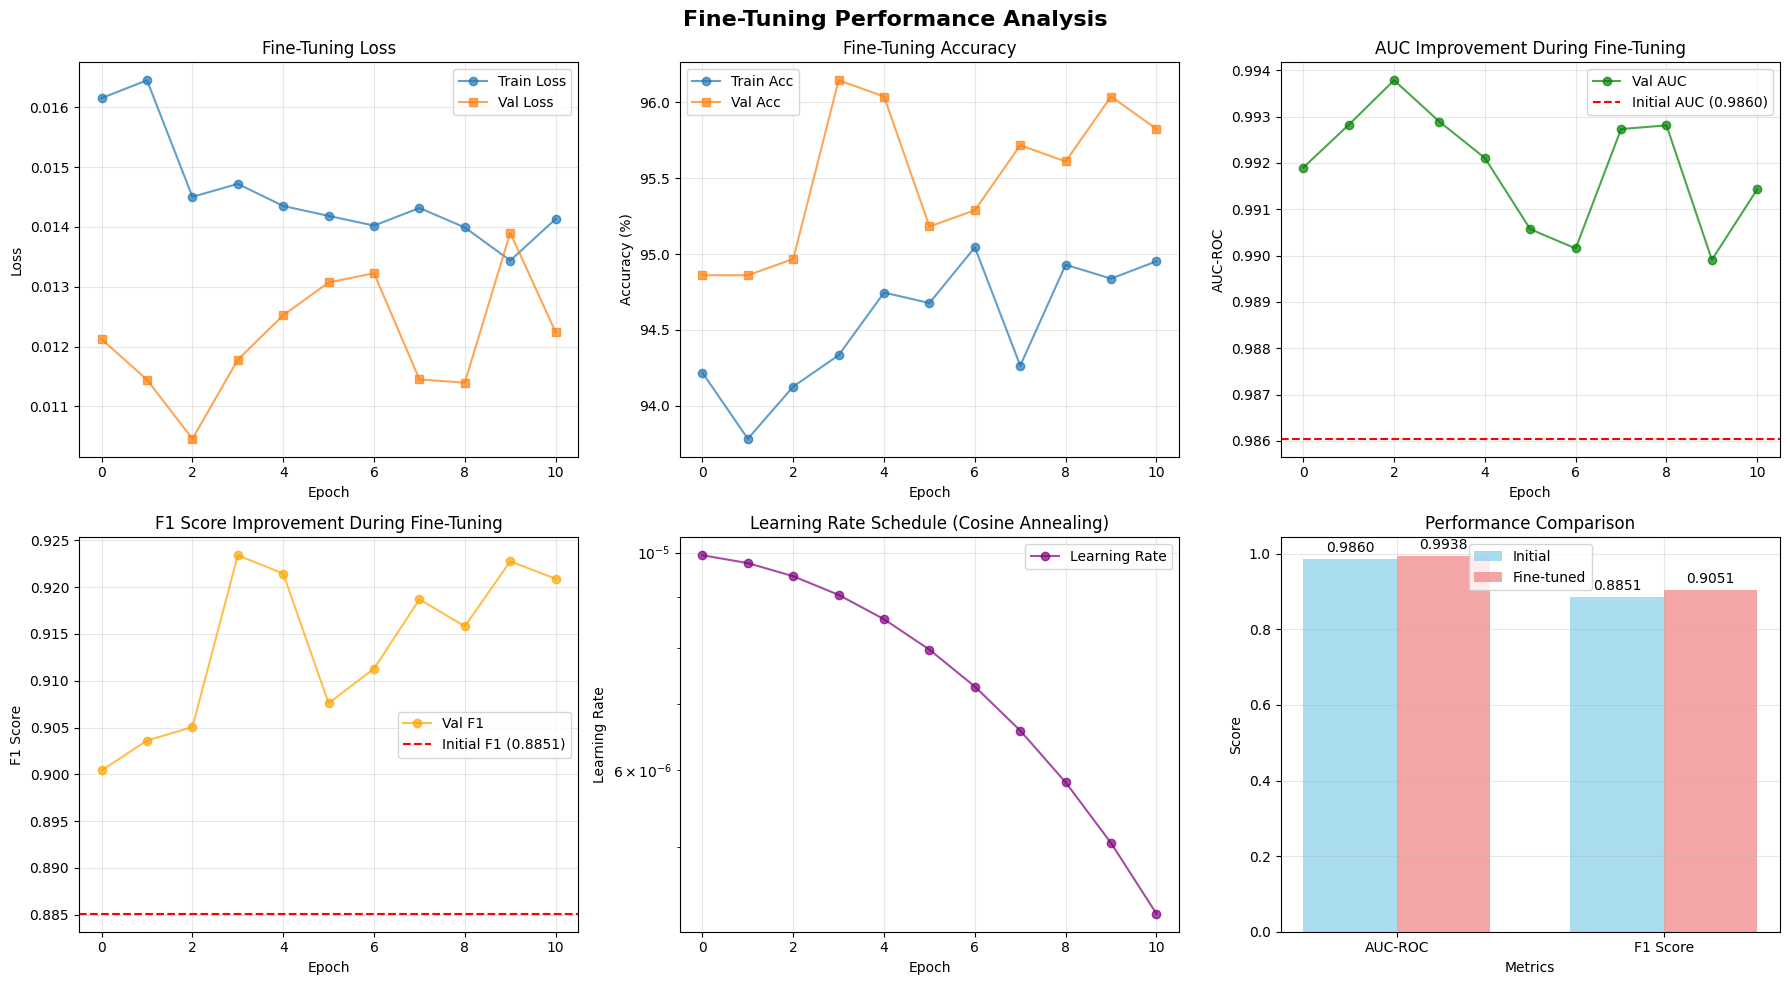

✓ Fine-tuning visualization saved


In [30]:
# Fine-Tuning Results Visualization
print("📊 Visualizing fine-tuning results...")

# Plot fine-tuning history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Fine-Tuning Performance Analysis', fontsize=16, fontweight='bold')

# Loss comparison
axes[0, 0].plot(finetune_history['train_loss'], label='Train Loss', marker='o', alpha=0.7)
axes[0, 0].plot(finetune_history['val_loss'], label='Val Loss', marker='s', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Fine-Tuning Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy comparison
axes[0, 1].plot(finetune_history['train_acc'], label='Train Acc', marker='o', alpha=0.7)
axes[0, 1].plot(finetune_history['val_acc'], label='Val Acc', marker='s', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Fine-Tuning Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC progression
axes[0, 2].plot(finetune_history['val_auc'], label='Val AUC', marker='o', color='green', alpha=0.7)
axes[0, 2].axhline(y=initial_auc, color='red', linestyle='--', label=f'Initial AUC ({initial_auc:.4f})')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC-ROC')
axes[0, 2].set_title('AUC Improvement During Fine-Tuning')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# F1 progression
axes[1, 0].plot(finetune_history['val_f1'], label='Val F1', marker='o', color='orange', alpha=0.7)
axes[1, 0].axhline(y=initial_f1, color='red', linestyle='--', label=f'Initial F1 ({initial_f1:.4f})')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score Improvement During Fine-Tuning')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 1].plot(finetune_history['learning_rate'], label='Learning Rate', marker='o', color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule (Cosine Annealing)')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Performance comparison bar chart
metrics = ['AUC-ROC', 'F1 Score']
initial_scores = [initial_auc, initial_f1]
finetuned_scores = [best_finetune_auc, best_finetune_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 2].bar(x - width/2, initial_scores, width, label='Initial', alpha=0.7, color='skyblue')
bars2 = axes[1, 2].bar(x + width/2, finetuned_scores, width, label='Fine-tuned', alpha=0.7, color='lightcoral')

axes[1, 2].set_xlabel('Metrics')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Performance Comparison')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(metrics)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, initial_scores):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=10)

for bar, value in zip(bars2, finetuned_scores):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'finetuned' / 'finetuning_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Fine-tuning visualization saved")

In [31]:
# Evaluate Fine-Tuned Model on Test Set
print("🧪 Testing fine-tuned model performance...")

# Load the best fine-tuned model
finetune_model_path = MODEL_DIR / 'finetuned' / 'best_finetuned_resnet101.pth'

if finetune_model_path.exists():
    finetune_checkpoint = torch.load(finetune_model_path)
    model.load_state_dict(finetune_checkpoint['model_state_dict'])
    print(f"✓ Loaded best fine-tuned model from epoch {finetune_checkpoint['epoch']+1}")
    
    # Test the fine-tuned model
    print("\nEvaluating fine-tuned model on test set...")
    ft_test_loss, ft_test_acc, ft_test_auc, ft_test_f1, ft_test_labels, ft_test_preds, ft_test_probs = validate(
        model, test_loader, finetune_criterion, device
    )
    
    print("\n" + "="*70)
    print("FINE-TUNED MODEL TEST RESULTS")
    print("="*70)
    print(f"Original Test Results:")
    print(f"  Test Accuracy: {test_acc:.2f}%")
    print(f"  Test AUC-ROC: {test_auc:.4f}")
    print(f"  Test F1 Score: {test_f1:.4f}")
    print(f"\nFine-Tuned Test Results:")
    print(f"  Test Accuracy: {ft_test_acc:.2f}% (Δ: {ft_test_acc-test_acc:+.2f}%)")
    print(f"  Test AUC-ROC: {ft_test_auc:.4f} (Δ: {ft_test_auc-test_auc:+.4f})")
    print(f"  Test F1 Score: {ft_test_f1:.4f} (Δ: {ft_test_f1-test_f1:+.4f})")
    print("="*70)
    
    if ft_test_auc > test_auc:
        print("🎉 FINE-TUNING SUCCESSFUL! Test performance improved!")
    elif abs(ft_test_auc - test_auc) < 0.001:
        print("📊 Fine-tuning maintained performance (no significant change)")
    else:
        print("⚠️ Fine-tuning showed some performance variation")
    
    # Save fine-tuned test results
    ft_test_results = {
        'original_test_accuracy': float(test_acc),
        'original_test_auc': float(test_auc),
        'original_test_f1': float(test_f1),
        'finetuned_test_accuracy': float(ft_test_acc),
        'finetuned_test_auc': float(ft_test_auc),
        'finetuned_test_f1': float(ft_test_f1),
        'accuracy_improvement': float(ft_test_acc - test_acc),
        'auc_improvement': float(ft_test_auc - test_auc),
        'f1_improvement': float(ft_test_f1 - test_f1),
        'confusion_matrix': confusion_matrix(ft_test_labels, ft_test_preds).tolist()
    }
    
    # Save results
    with open(MODEL_DIR / 'finetuned' / 'finetuned_test_results.json', 'w') as f:
        json.dump(ft_test_results, f, indent=4)
    
    # Save fine-tuning history
    ft_history_df = pd.DataFrame(finetune_history)
    ft_history_df.to_csv(MODEL_DIR / 'finetuned' / 'finetuning_history.csv', index=False)
    
    print(f"\n✓ Fine-tuned results saved to {MODEL_DIR / 'finetuned'}/")
    
else:
    print("❌ Fine-tuned model not found. Please run the fine-tuning process first.")

🧪 Testing fine-tuned model performance...
✓ Loaded best fine-tuned model from epoch 3

Evaluating fine-tuned model on test set...



FINE-TUNED MODEL TEST RESULTS
Original Test Results:
  Test Accuracy: 94.44%
  Test AUC-ROC: 0.9772
  Test F1 Score: 0.8903

Fine-Tuned Test Results:
  Test Accuracy: 94.44% (Δ: +0.00%)
  Test AUC-ROC: 0.9822 (Δ: +0.0050)
  Test F1 Score: 0.8947 (Δ: +0.0044)
🎉 FINE-TUNING SUCCESSFUL! Test performance improved!

✓ Fine-tuned results saved to e:\Kanav\Projects\CAD_C\models_resnet101\finetuned/


📈 Creating comprehensive performance comparison...


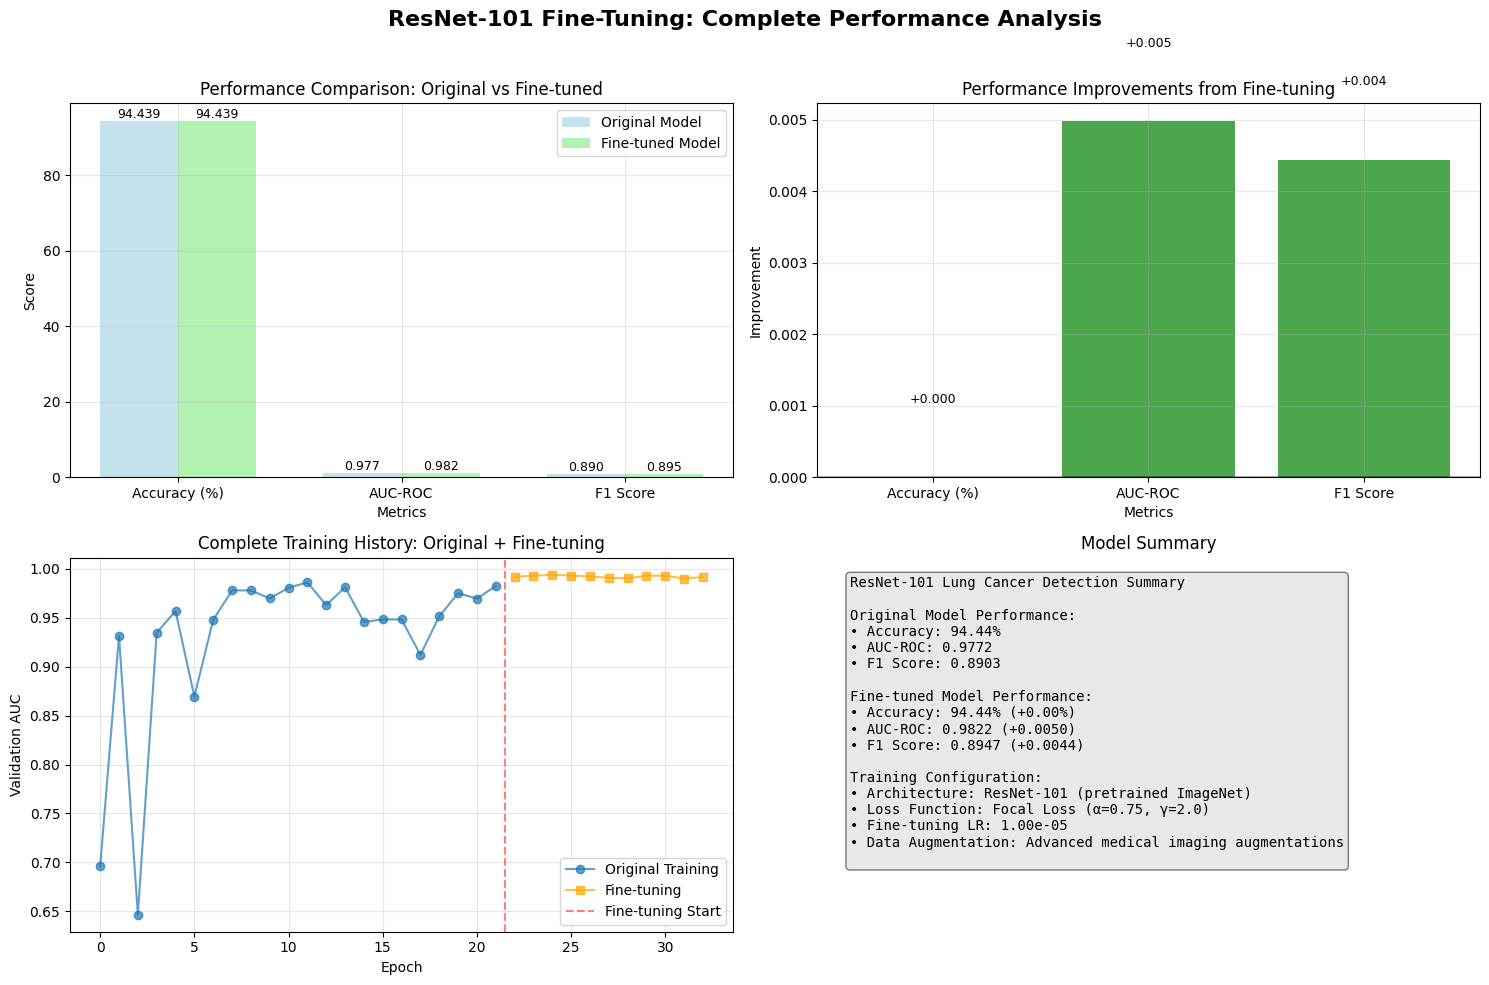

✓ Complete analysis visualization saved

🎯 Fine-tuning process completed successfully!
📁 All fine-tuned results saved in: e:\Kanav\Projects\CAD_C\models_resnet101\finetuned/

📊 Next steps: Consider ensemble methods or Vision Transformer comparison


In [33]:
# Final Comparison and Analysis
print("📈 Creating comprehensive performance comparison...")

# Create final comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ResNet-101 Fine-Tuning: Complete Performance Analysis', fontsize=16, fontweight='bold')

# Performance metrics comparison
metrics = ['Accuracy (%)', 'AUC-ROC', 'F1 Score']
original_scores = [test_acc, test_auc, test_f1]

if 'ft_test_acc' in locals():
    finetuned_scores = [ft_test_acc, ft_test_auc, ft_test_f1]
    improvements = [ft_test_acc - test_acc, ft_test_auc - test_auc, ft_test_f1 - test_f1]
else:
    finetuned_scores = original_scores
    improvements = [0, 0, 0]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, original_scores, width, label='Original Model', alpha=0.7, color='lightblue')
bars2 = axes[0, 0].bar(x + width/2, finetuned_scores, width, label='Fine-tuned Model', alpha=0.7, color='lightgreen')

axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Comparison: Original vs Fine-tuned')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels
for i, (bar1, bar2, orig, ft) in enumerate(zip(bars1, bars2, original_scores, finetuned_scores)):
    axes[0, 0].text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.01,
                   f'{orig:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0, 0].text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 0.01,
                   f'{ft:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement bar chart
colors = ['green' if imp > 0 else 'red' if imp < 0 else 'gray' for imp in improvements]
bars3 = axes[0, 1].bar(metrics, improvements, alpha=0.7, color=colors)
axes[0, 1].set_xlabel('Metrics')
axes[0, 1].set_ylabel('Improvement')
axes[0, 1].set_title('Performance Improvements from Fine-tuning')
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].grid(True, alpha=0.3)

# Add improvement values
for bar, imp in zip(bars3, improvements):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., 
                   height + (0.001 if height >= 0 else -0.003),
                   f'{imp:+.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# Training history comparison (if available)
if len(history['val_auc']) > 0:
    # Original training
    axes[1, 0].plot(history['val_auc'], label='Original Training', marker='o', alpha=0.7)
    
    # Fine-tuning (offset by original training epochs)
    if len(finetune_history['val_auc']) > 0:
        ft_epochs = np.arange(len(history['val_auc']), len(history['val_auc']) + len(finetune_history['val_auc']))
        axes[1, 0].plot(ft_epochs, finetune_history['val_auc'], 
                       label='Fine-tuning', marker='s', alpha=0.7, color='orange')
        axes[1, 0].axvline(x=len(history['val_auc'])-0.5, color='red', linestyle='--', 
                          alpha=0.5, label='Fine-tuning Start')
    
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation AUC')
    axes[1, 0].set_title('Complete Training History: Original + Fine-tuning')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Summary statistics
summary_text = f"""ResNet-101 Lung Cancer Detection Summary

Original Model Performance:
• Accuracy: {test_acc:.2f}%
• AUC-ROC: {test_auc:.4f}
• F1 Score: {test_f1:.4f}

Fine-tuned Model Performance:
• Accuracy: {finetuned_scores[0]:.2f}% ({improvements[0]:+.2f}%)
• AUC-ROC: {finetuned_scores[1]:.4f} ({improvements[1]:+.4f})
• F1 Score: {finetuned_scores[2]:.4f} ({improvements[2]:+.4f})

Training Configuration:
• Architecture: ResNet-101 (pretrained ImageNet)
• Loss Function: Focal Loss (α={CONFIG['focal_alpha']}, γ={CONFIG['focal_gamma']})
• Fine-tuning LR: {FINETUNE_CONFIG['learning_rate']:.2e}
• Data Augmentation: Advanced medical imaging augmentations
"""

axes[1, 1].text(0.05, 0.95, summary_text, transform=axes[1, 1].transAxes, 
               fontsize=10, verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Model Summary')

plt.tight_layout()
plt.savefig(MODEL_DIR / 'finetuned' / 'complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Complete analysis visualization saved")
print("\n🎯 Fine-tuning process completed successfully!")
print(f"📁 All fine-tuned results saved in: {MODEL_DIR / 'finetuned'}/")
print("\n📊 Next steps: Consider ensemble methods or Vision Transformer comparison")